In [3]:
import json
import os
import glob
import pandas as pd

In [4]:
os.chdir("asset")
extension = 'json'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [5]:
tweets = []
for file in all_filenames:
    for line in open( file, 'r'):
        tweets.append(json.loads(line))

In [6]:
#clean duplicate
id_list=[]
new_tweets=[]
text_list=[]
for tweet in tweets:
    if tweet['id'] not in id_list:
        new_tweets.append(tweet)
        id_list.append(tweet['id'])
        text_list.append(tweet['text'])

In [7]:
len(new_tweets)

6123

In [8]:
# time convertion to LA timezone
from datetime import datetime
from email.utils import parsedate_tz, mktime_tz

def to_local_time(tweet_time_string):
   
    timestamp = mktime_tz(parsedate_tz(tweet_time_string))
    return datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

In [9]:
df = pd.DataFrame([{"tweet_id": x['id'],
                         "date": to_local_time(x['created_at']),
                         "text": x['text'],                    
                         "favorite_count":x['favorite_count'],
                         'retweet_count':x['retweet_count'],
                         "at_mentions": [u["name"] for u in x['entities']['user_mentions']],
                         "at_mentions_id": [u["id"] for u in x['entities']['user_mentions']],
                         "hashtags": [v['text'] for v in x['entities']['hashtags']],
                         "user_id": x['user']['id'],
                         'user_name':x['user']['name'],
                         'user_profile':x['user']['description'],
                         'in_reply_to_tweet_id':x['in_reply_to_status_id'],
                         'country':x['place']['country'],
                          'place':x['place']['name'],
                          'lang':x['lang'],
                         'coordinates':x['place']['bounding_box']['coordinates'][0][0]} for x in new_tweets]).set_index("tweet_id")

In [10]:
df_US_origin=df[df['country'] == 'United States']

In [11]:
df_US_origin=df[df['lang'] == 'en']

In [12]:
df_US_origin[['latitude','longitude']]=pd.DataFrame(df_US_origin.coordinates.values.tolist(), 
                                                    index=df_US_origin.index, columns=['latitude','longitude'])

C:\Users\Think\A3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [13]:
df_US_origin['at_mentions']

tweet_id
1239358160105857024                           [Traci Blackmon, NAACP]
1239358141869035526                                                []
1239358032716365825                                                []
1239358007282106368                                                []
1239357938998939650                                                []
                                            ...                      
1240616013814738945                 [Klaus Iohannis, President Trump]
1240615999751192577    [Lori Lightfoot, JB Pritzker, President Trump]
1240615983808733186                         [LifeLine Animal Project]
1240615967786446849                                                []
1240615950577283073             [Garrett Haake, Governor Mike DeWine]
Name: at_mentions, Length: 5919, dtype: object

In [14]:
os.chdir("record")

df_US_origin.to_csv("origin_data.csv")

In [15]:
#Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):

    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[@%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', ' ', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [16]:
def clean_text_round2(text):
    text = re.sub('[‘’“”…]', ' ', text)
    text = re.sub('\n', ' ', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [17]:
df_US_origin['tidy_text'] = df_US_origin.text.apply(round1).apply(round2)
df_US=df_US_origin

C:\Users\Think\A3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Word Frequency

In [18]:
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer

def tweet_tokenizer(verbatim):
    try:
        tokenizer = TweetTokenizer()
        all_tokens = tokenizer.tokenize(verbatim.lower())
        filtered_tokens = [t for t in all_tokens if t.islower()]
        filtered_tokens = [x for x in filtered_tokens if len(x)>2]
    except IndexError:
        filtered_tokens = []
    return(filtered_tokens)

In [19]:
# get the most common words in Tweets
from sklearn.feature_extraction.text import CountVectorizer

def get_frequent_terms(text_series, stop_words = None, ngram_range = (1,2)):
    
    count_vectorizer = CountVectorizer(analyzer = "word",
                                       tokenizer = tweet_tokenizer,
                                       stop_words = stop_words, 
                                       ngram_range = ngram_range)
    term_freq_matrix = count_vectorizer.fit_transform(text_series)
    terms = count_vectorizer.get_feature_names()
    term_frequencies = term_freq_matrix.sum(axis = 0).tolist()[0]

    term_freq_df = (pd.DataFrame(list(zip(terms, term_frequencies)), columns = ["token","count"])
                    .set_index("token")
                    .sort_values("count",ascending = False))
    return term_freq_df

In [20]:
term_freq_df = get_frequent_terms(df_US["tidy_text"], stop_words = "english")
term_freq_df.to_csv("term_freq.csv")

In [21]:
# all the words
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

stopwords = set(STOPWORDS)
pattern = np.array(Image.open("../pic/USA_map.png"))
wordcloud=WordCloud(background_color="white", max_words=2000, mask=pattern,
               stopwords=stopwords, contour_width=1, contour_color='steelblue', width=1024, height=720).generate_from_frequencies(frequencies=term_freq_df['count'])
plt.figure(figsize=(50,10))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show()
wordcloud.to_file("../wordcloud/term_freqs.png")

<Figure size 5000x1000 with 1 Axes>

In [22]:
## remove words used when searching data
term_freq_cl=term_freq_df[~term_freq_df.index.isin(['coronavirususa','coronavirus','realdonaldtrump','trump','amp'])]

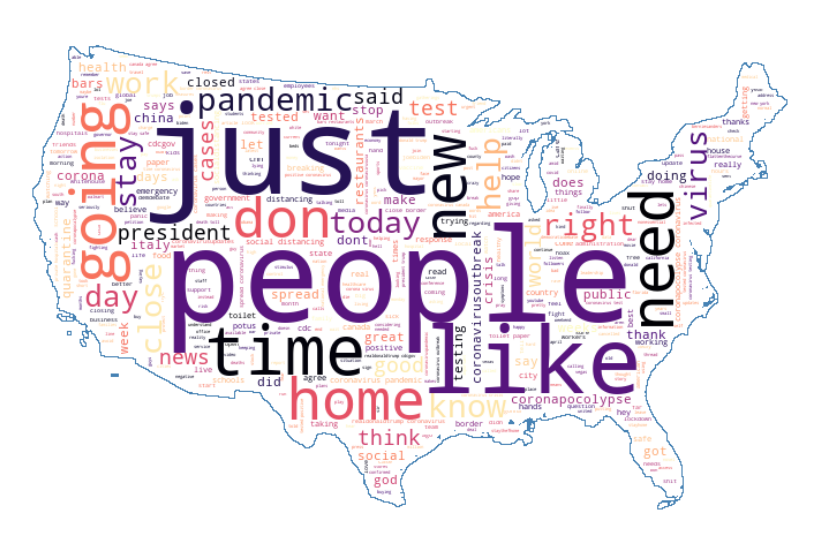

In [23]:
pattern = np.array(Image.open("../pic/USA_map.png"))
wordcloud=WordCloud(background_color="white", max_words=2000, mask=pattern,colormap='magma',
               stopwords=stopwords, contour_width=1, contour_color='steelblue', width=1024, height=720).generate_from_frequencies(frequencies=term_freq_cl['count'])
plt.figure(figsize=(50,10))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show()
wordcloud.to_file("../wordcloud/term_freqs_cl.png")

### what most people care about among 'heat' tweets?

In [24]:
df_US['heat']=df_US['favorite_count']+df_US['retweet_count']

C:\Users\Think\A3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
df_hottopic=df_US.sort_values(by=['heat'],ascending=False)
df_hottopic_filter=df_hottopic[df_hottopic['heat']>=df_hottopic['heat'].mean()]

In [26]:
df_hottopic_freq=get_frequent_terms(df_hottopic_filter["tidy_text"], stop_words = "english")

In [27]:
df_hottopic_freq.to_csv("hottopic_freq.csv")

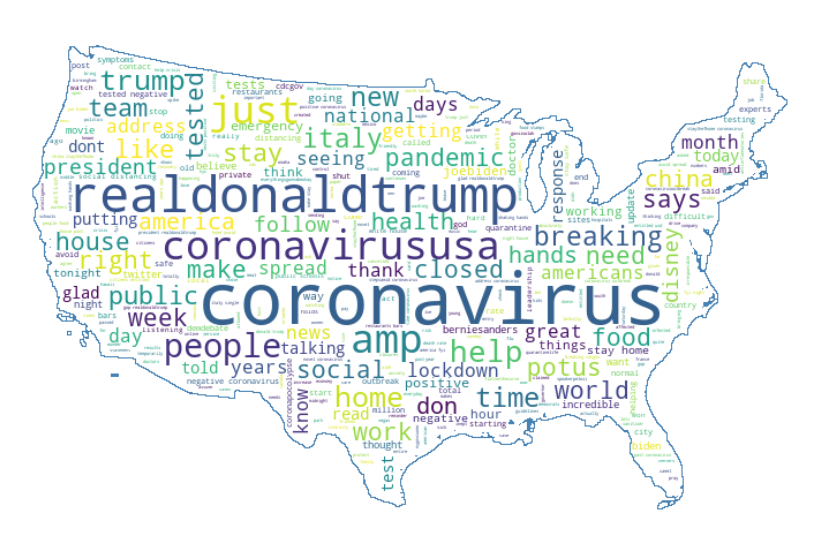

In [28]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

stopwords = set(STOPWORDS)
stopwords.add("token")
pattern = np.array(Image.open("../pic/USA_map.png"))
wordcloud=WordCloud(background_color="white", max_words=2000, mask=pattern,
               stopwords=stopwords, contour_width=1, contour_color='steelblue', width=1024, height=720).generate_from_frequencies(frequencies=df_hottopic_freq['count'])
plt.figure(figsize=(50,10))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show()
wordcloud.to_file("../wordcloud/hottopics_freqs.png")

In [29]:
## remove words used when searching data
df_hottopic_cl=df_hottopic_freq[~df_hottopic_freq.index.isin(['coronavirususa','coronavirus','realdonaldtrump','trump','amp'])]

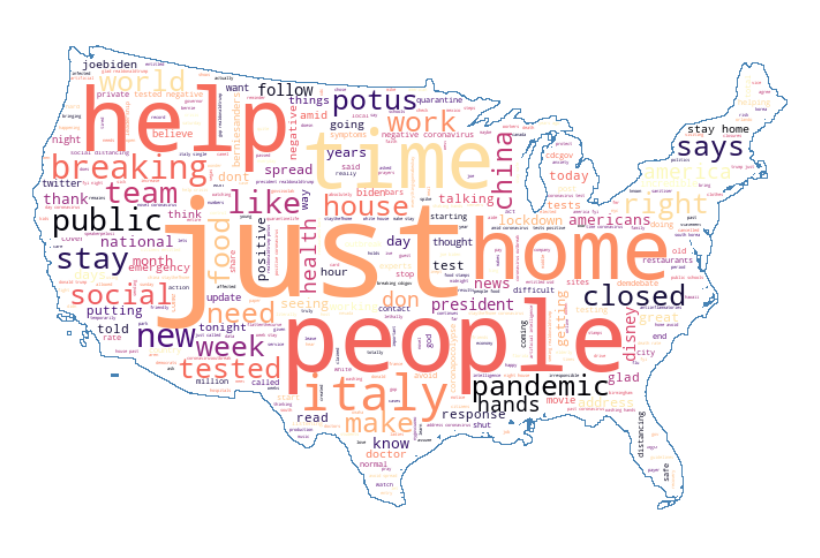

In [30]:
pattern = np.array(Image.open("../pic/USA_map.png"))
wordcloud=WordCloud(background_color="white", max_words=2000, mask=pattern,colormap='magma',
               stopwords=stopwords, contour_width=1, contour_color='steelblue', width=1024, height=720).generate_from_frequencies(frequencies=df_hottopic_cl['count'])
plt.figure(figsize=(50,10))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show()
wordcloud.to_file("../wordcloud/hottopics_freqs_cl.png")

### Who was mentioned most?

In [32]:
df_atmentions=explode(df_US, ['at_mentions','at_mentions_id'], fill_value='')

In [33]:
df_mentions=df_atmentions.groupby(['at_mentions']).count().filter(['user_id']).sort_values(by=['user_id'], ascending =False)[1:]

In [34]:
df_mentions[df_mentions['user_id']>10]

,user_id
at_mentions,
Donald J. Trump,1023
President Trump,62
CDC,58
Vice President Mike Pence,53
Joe Biden (Text Join to 30330),37
GOP,36
The White House,35
CNN,29
Bernie Sanders,28


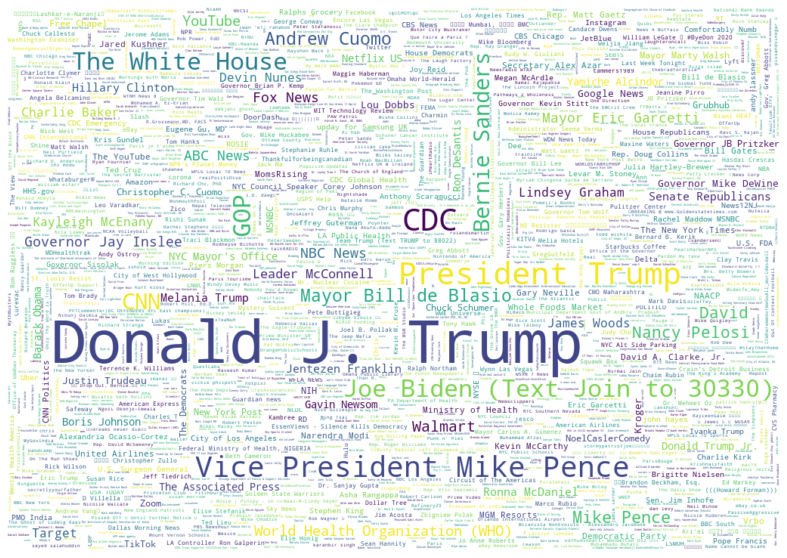

In [35]:
wordcloud=WordCloud(background_color="white", max_words=2000,stopwords=stopwords,
                    width=1024, height=720).generate_from_frequencies(frequencies=df_mentions['user_id'])
plt.figure(figsize=(50,10))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show()
wordcloud.to_file("../wordcloud/at_mentions.png")